## Dog Breed Prediction

In [1]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"diksha1312","key":"9f09525a663b4ecc1e67928c735aaaf3"}'}

In [2]:
# Install the Kaggle API client.
!pip install -q kaggle

In [3]:
# The Kaggle API client expects this file to be in ~/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Creating directory and changing the current working directory
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


In [5]:
# Searching for dataset
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           6111          8  0.1764706        


In [6]:
# Downloading dataset
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

Dataset URL: https://www.kaggle.com/datasets/catherinehorng/dogbreedidfromcomp
License(s): unknown
100% 689M/691M [00:35<00:00, 23.8MB/s]
100% 691M/691M [00:35<00:00, 20.3MB/s]
/content


After searching the data next step would be downloading the data into collab notebook using references found in search option.

In [7]:
# Unzipping downloaded file
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
# Remove unusable files
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv

Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91b

In [8]:
# Important library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam

In [14]:
# Read the labels.csv file and checking shape and records
dataset_all = pd.read_csv("dog_dataset/labels.csv")
print(dataset_all.shape)
dataset_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [15]:
# Visualize the number of each breeds
breeds_all = dataset_all["breed"]
breed_counts = breeds_all.value_counts()
breed_counts.head()

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: count, dtype: int64

In [17]:
# Selecting first 3 breeds (Limitation due to computation power)
CLASS_NAMES = ['scottish_deerhound', 'entlebucher', 'maltese_dog']
data = dataset_all[(dataset_all['breed'].isin(CLASS_NAMES))]
data = data.reset_index()
data.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,80,01ee3c7ff9bcaba9874183135877670e,entlebucher
4,88,021b5a49189665c0442c19b5b33e8cf1,entlebucher


In [18]:
# Creating numpy matrix with zeros
X_data = np.zeros((len(data), 224, 224, 3), dtype='float32')
# One hot encoding
Y_data = label_binarize(data['breed'], classes = CLASS_NAMES)
# print("Labels after OHE:",Y_data)

# Reading and converting image to numpy array and normalizing dataset
for i in tqdm(range(len(data))):
    img = image.load_img('dog_dataset/train/%s.jpg' % data['id'][i], target_size=(224, 224))
    img = image.img_to_array(img)
    x = np.expand_dims(img.copy(), axis=0)
    X_data[i] = x / 255.0 # Normalizing dataset

# Printing train image and one hot encode shape & size
print('\nTrain Images shape: ',X_data.shape,' size: {:,}'.format(X_data.size))
print('One-hot encoded output shape: ',Y_data.shape,' size: {:,}'.format(Y_data.size))

100%|██████████| 358/358 [00:01<00:00, 340.01it/s]


Train Images shape:  (358, 224, 224, 3)  size: 53,889,024
One-hot encoded output shape:  (358, 3)  size: 1,074


In [19]:
# Building the Model
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), activation ='relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (7,7), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 8, kernel_size = (5,5), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(64, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(len(CLASS_NAMES), activation = "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 24, 24, 16)        0

In [20]:
# Splitting the data set into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size = 0.1)
# Splitting the training data set into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2)

In [21]:
# Training the model
epochs = 100
batch_size = 128

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, Y_val))

Epoch 1/100
3/3 [==============================] - 15s 1s/step - loss: 4.8940 - accuracy: 0.3424 - val_loss: 4.8677 - val_accuracy: 0.3385
Epoch 2/100
3/3 [==============================] - 0s 144ms/step - loss: 4.8576 - accuracy: 0.3424 - val_loss: 4.8339 - val_accuracy: 0.3385
Epoch 3/100
3/3 [==============================] - 0s 146ms/step - loss: 4.8278 - accuracy: 0.3424 - val_loss: 4.8028 - val_accuracy: 0.3385
Epoch 4/100
3/3 [==============================] - 0s 143ms/step - loss: 4.7973 - accuracy: 0.3424 - val_loss: 4.7726 - val_accuracy: 0.3385
Epoch 5/100
3/3 [==============================] - 1s 156ms/step - loss: 4.7660 - accuracy: 0.3424 - val_loss: 4.7418 - val_accuracy: 0.3385
Epoch 6/100
3/3 [==============================] - 1s 198ms/step - loss: 4.7353 - accuracy: 0.3424 - val_loss: 4.7111 - val_accuracy: 0.3385
Epoch 7/100
3/3 [==============================] - 1s 203ms/step - loss: 4.7044 - accuracy: 0.3424 - val_loss: 4.6805 - val_accuracy: 0.3385
Epoch 8/100
3/3

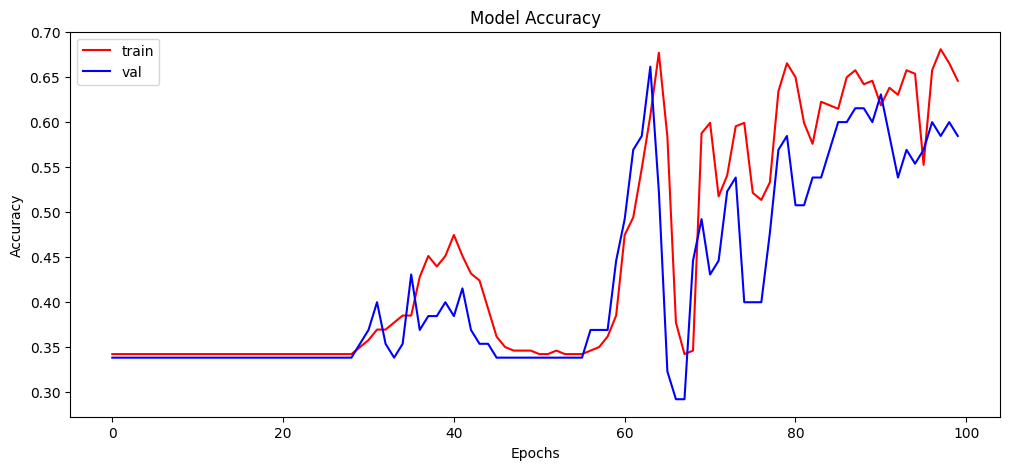

In [22]:
# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [23]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

2/2 [==============================] - 0s 13ms/step - loss: 2.9012 - accuracy: 0.6667
Accuracy over the test set: 
  66.67 %


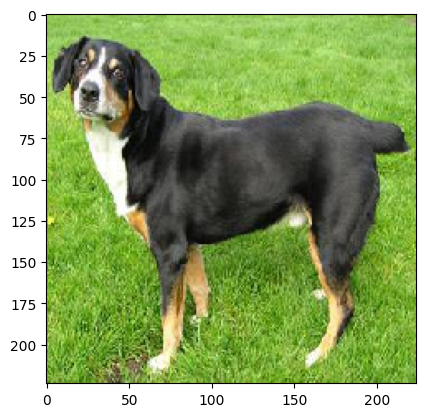

Originally :  maltese_dog
Predicted :  maltese_dog


In [27]:
# Plotting image to compare
plt.imshow(X_test[2,:,:,:])
plt.show()

# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",data['breed'][np.argmax(Y_test[2])])
print("Predicted : ",data['breed'][np.argmax(Y_pred[2])])

## Conclusion:

This model can be used to predict different breeds of dogs which can be further used by different NGO's working on saving animals and for educational purposes also.

In [33]:
model.save("dog_breed.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
